In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
%matplotlib inline  
plt.style.use('fivethirtyeight')
seed=45

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#DOUBTS
#How to decide if credit_history variable is non-numerical?
#Ans:-credit_history is a nominal variable
#How to print multiple graphs in one figure
# is credit_history category or bindary or interval variable?
#Ans:-credit_history is a nominal variable
# is gender, married etc. are careorical or binary variable?
#Ans:-gender, married etc are nominal variables
# is dependents is a oridnal varialble or categorical variable
#Ans:-dependents is nominal variable
# is loan status is binary or categorical variable?
#Ans:-loan_status is nominal variable

#TODOs
#write a loop to print multiple graphs for all numerical variables against all categorical variables 
#to analyze infomration in more detail
# TODO:create plot of loan status of applicants using credit history and gender variable stacked together.i.e 
#You can also add gender into the mix  HOW????
#Write a code to plot the graph to test this -A key hypothesis is that the whether a person is educated or 
#self-employed can combine to give a good estimate of loan amount.

In [3]:
df_raw=pd.read_csv("./input/train.csv")
#test=pd.read_csv("./input/test.csv")
df_raw.head()
#train.tail()
#df.describe() # Get summary of numerical variables
#df.shape
#df.dtypes
#df.info()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df_raw.shape

(614, 13)

In [5]:
#Check if there is any class imbalance on target column
target_col='Loan_Status'
df_raw[target_col].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [6]:
#Split data first.
X=df_raw.drop(columns=[target_col])
y=df_raw[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
586,LP002916,Male,Yes,0,Graduate,No,2297,1522.0,104.0,360.0,1.0,Urban
321,LP002053,Male,Yes,3+,Graduate,No,4342,189.0,124.0,360.0,1.0,Semiurban
396,LP002277,Female,No,0,Graduate,No,3180,0.0,71.0,360.0,0.0,Urban
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban
132,LP001478,Male,No,0,Graduate,No,2718,0.0,70.0,360.0,1.0,Semiurban


In [7]:
# Add target column to X_train for EDA purpose and remove it before model fitting
#X_train[target_col]=y
#X_train.head()
X_train['Dependents'].unique()

array(['0', '3+', nan, '2', '1'], dtype=object)

In [8]:
#Create a meta data table to distinguish levels of data columns
data = []
for f in X_train.columns:
    # Defining the role
    if f == 'Loan_Status':
        role = 'target'
    elif f == 'Loan_ID':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if f == 'Gender' or f == 'Married' or f == 'Education' or f == 'Credit_History' or f == 'Self_Employed' or f == 'Property_Area' or f == 'Loan_Status':
        level = 'nominal' 
    elif X_train[f].dtype == 'int64' :
        level = 'interval'
    elif X_train[f].dtype == 'float64' and f != 'Credit_History':
        level = 'ratio'
    elif   f == 'Loan_ID' or f == 'Dependents':
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    #if f == 'Loan_ID':
     #   keep = False
    
    # Defining the data type 
    dtype = X_train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
Loan_ID,id,ordinal,True,object
Gender,input,nominal,True,object
Married,input,nominal,True,object
Dependents,input,ordinal,True,object
Education,input,nominal,True,object
Self_Employed,input,nominal,True,object
ApplicantIncome,input,interval,True,int64
CoapplicantIncome,input,ratio,True,float64
LoanAmount,input,ratio,True,float64


In [9]:
#Check the value counts of nominal variables
nominal_ordinal_cols = meta[(meta.level == 'nominal' ) | (meta.level == 'ordinal') & (meta.keep)].index
for f in nominal_ordinal_cols:
    dist_values = X_train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Loan_ID has 460 distinct values
Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Dependents has 4 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values


In [10]:
nominal_cols = meta[(meta.level == 'nominal' ) & (meta.keep)].index
for f in nominal_cols:
    dist_values = X_train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable Gender has 2 distinct values
Variable Married has 2 distinct values
Variable Education has 2 distinct values
Variable Self_Employed has 2 distinct values
Variable Credit_History has 2 distinct values
Variable Property_Area has 3 distinct values


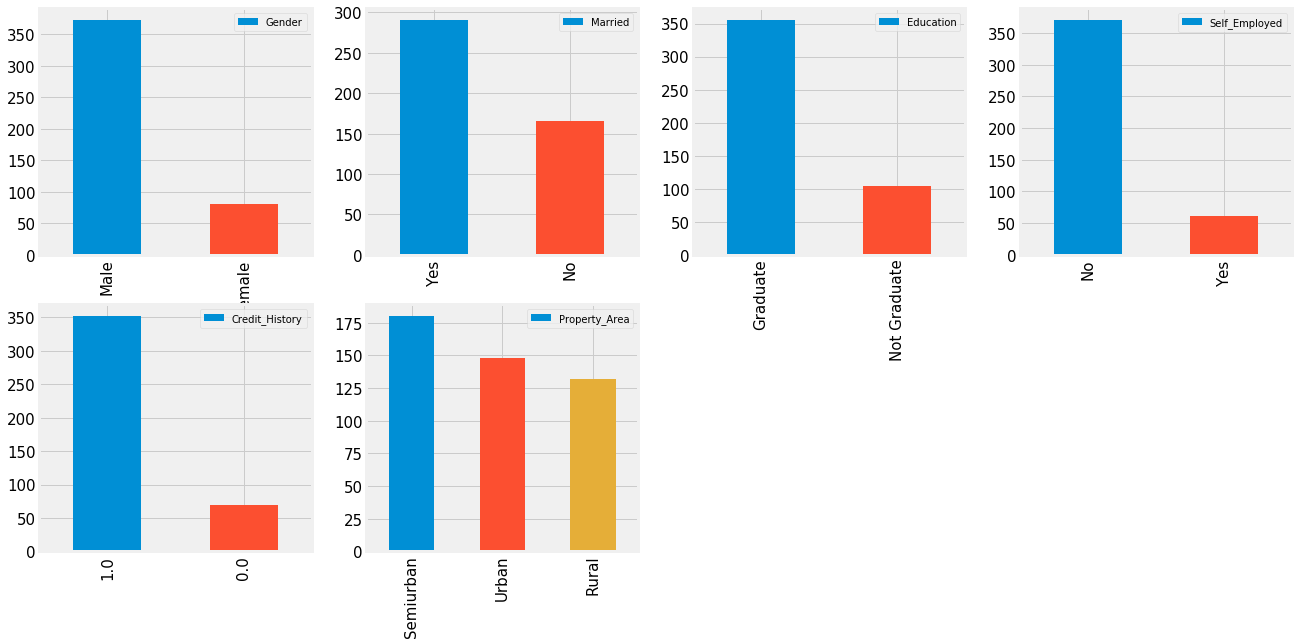

In [11]:
#plot nominal variables
fig = plt.figure()
i=1
for f in nominal_cols:
    axi = fig.add_subplot(2, 4,i)
    X_train[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
    i=i+1   


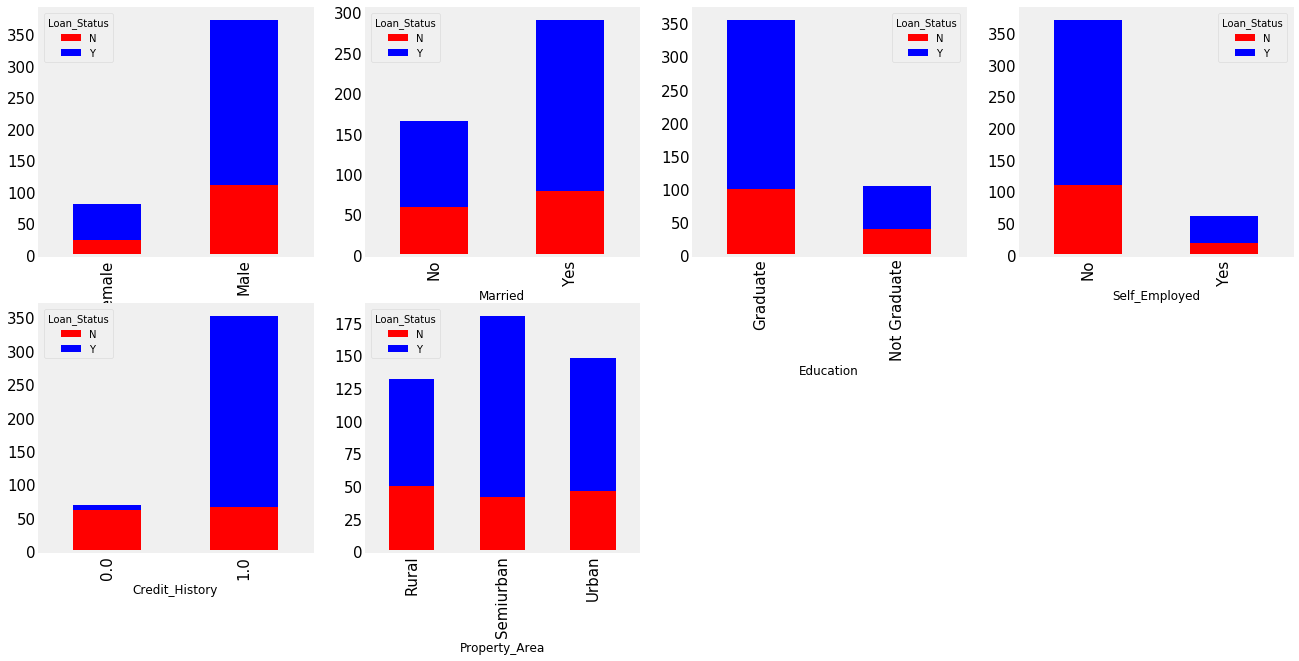

In [12]:
#plot nominal variables with target variable information
#v = meta[(meta.level == 'nominal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in nominal_cols:
    if f != 'Loan_Status' :
        axi = fig.add_subplot(2, 4,i)
        temp = pd.crosstab(X_train[f], y_train)
        #df[f].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1



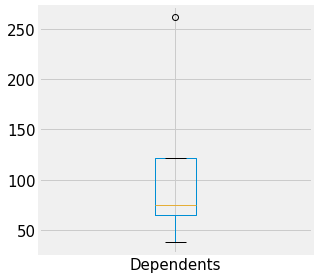

In [13]:
#plot nominal variables with target variable information
ordinal_cols = meta[(meta.level == 'ordinal' ) & (meta.keep)].index
fig = plt.figure()
i=1
for f in ordinal_cols:
    if f != 'Loan_ID' :
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].value_counts().sort_values(ascending=False).plot(kind='box',fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        #temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1

In [14]:
def summarize(data):
    """Create a summary of the input data including min, max,
    mean, median, num obs missing, IQR, etc.
    
    Parameters
    ----------
    data : pd.DataFrame
        The input dataframe to summarize.
    """
    summ = data.describe()
    
    # get the median, name it
    med = data.median()
    med.name = "median"
    
    # append the median row
    summ = summ.append(med, ignore_index=False)
    
    return summ

In [15]:
#Get summary of numerical variables
ratio_interval_cols = meta[( meta.level == 'ratio') | (meta.level == 'interval') & (meta.keep)].index
#df[v].describe()
summarize(X_train[ratio_interval_cols])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,460.000000,460.000000,443.000000,448.000000
mean,5556.543478,1541.375652,145.568849,341.598214
std,6453.678536,3074.940947,85.517491,64.463501
min,150.000000,0.000000,25.000000,12.000000
25%,2887.250000,0.000000,100.000000,360.000000
50%,3812.500000,1007.000000,126.000000,360.000000
75%,5818.750000,2193.250000,164.500000,360.000000
max,81000.000000,41667.000000,650.000000,480.000000
median,3812.500000,1007.000000,126.000000,360.000000


In [16]:
'''
for col in ratio_interval_cols:    
    plt.hist(X_train[y_train=='Y'][col], 10, alpha=0.5, label='Loan Approved')
    plt.hist(X_train[y_train=='N'][col], 10, alpha=0.5, label='Loan Denied')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()'''

"\nfor col in ratio_interval_cols:    \n    plt.hist(X_train[y_train=='Y'][col], 10, alpha=0.5, label='Loan Approved')\n    plt.hist(X_train[y_train=='N'][col], 10, alpha=0.5, label='Loan Denied')\n    plt.legend(loc='upper right')\n    plt.xlabel(col)\n    plt.ylabel('Frequency')\n    plt.title('Histogram of {}'.format(col))\n    plt.show()"

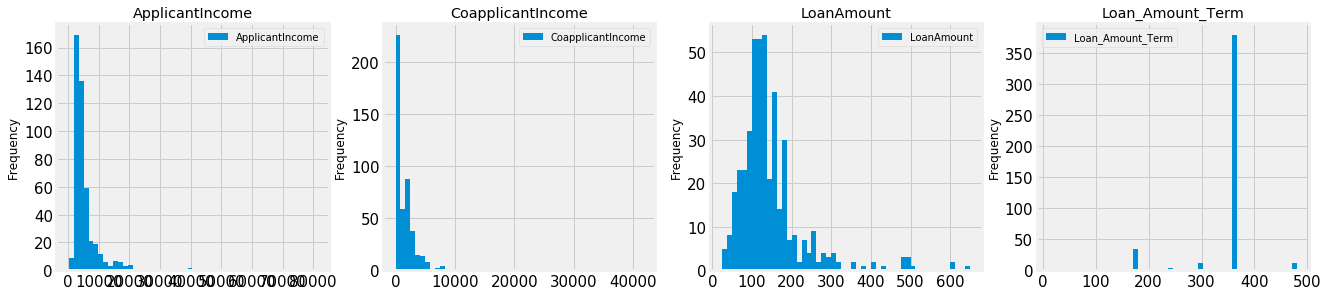

In [17]:
#plot interval variables
#v = meta[(meta.level == 'ratio' ) | (meta.level == 'interval') & (meta.keep)].index
fig = plt.figure()
i=1
for f in ratio_interval_cols:
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].plot(kind='hist',fontsize=15,legend='true',title=f,figsize=(20, 10),ax=axi,bins=50)        
        #temp.plot(kind='hist', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        # axi.hist(temp)
        i=i+1
        


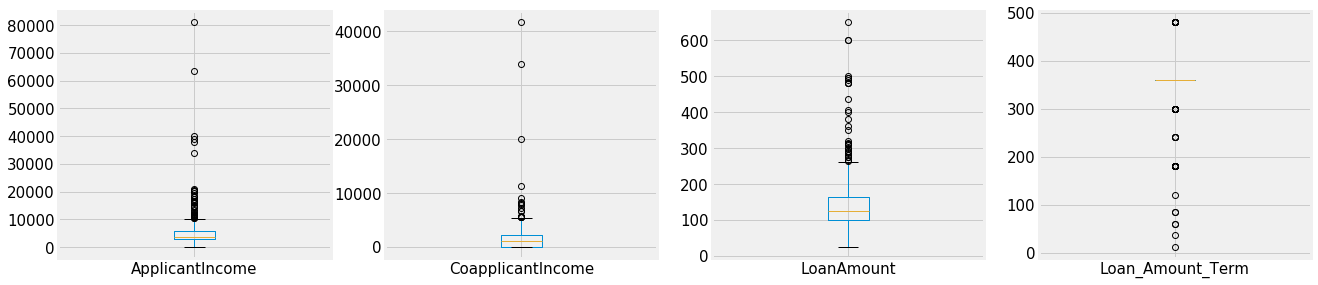

In [18]:
#plot interval variables
#v = meta[(meta.level == 'ratio' ) | (meta.level == 'interval') & (meta.keep)].index
fig = plt.figure()
i=1
for f in ratio_interval_cols:
        axi = fig.add_subplot(2, 4,i)
        #temp = pd.crosstab(df[f], df['Loan_Status'])
        X_train[f].plot(kind='box',fontsize=15,legend='true',figsize=(20, 10),ax=axi)        
        #temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=False,fontsize=15,legend='true',figsize=(20, 10),ax=axi)
        i=i+1

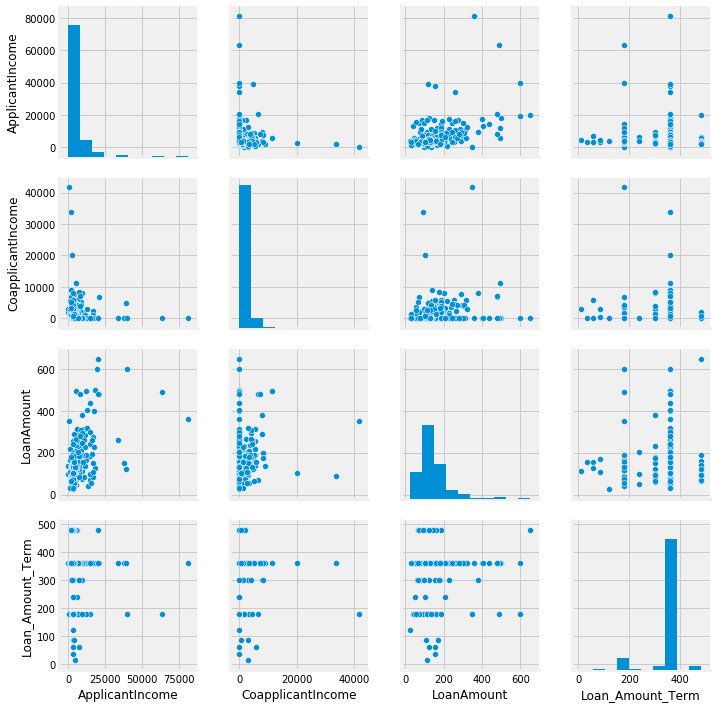

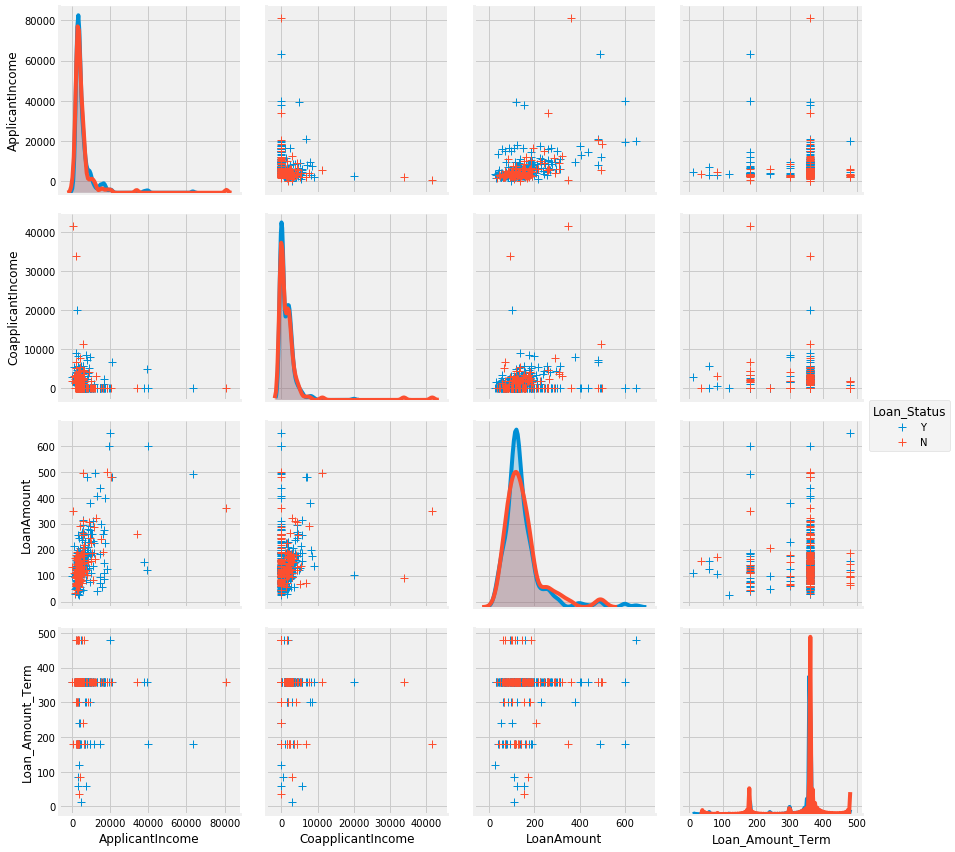

In [19]:
def pairplots(data, target_col_name,plot_type):
    # need to append target
    data = data.copy()  
    data[target_col_name]=y_train
    # get rid of NA to avoid warnings in seaborn
    data = data.dropna()
    if plot_type=='default' :
        sns.pairplot(data)
    else :
         #make a KDE pairplot
             sns.pairplot(data, diag_kind="kde", markers="+",
                            plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                             diag_kws=dict(shade=True), hue=target_col_name,
                            size=3)
pairplots(X_train[ratio_interval_cols], 'Loan_Status','default')
pairplots(X_train[ratio_interval_cols], 'Loan_Status','kde')

In [20]:
corr = X_train[ratio_interval_cols].corr()

# color map (https://stackoverflow.com/questions/39409866/correlation-heatmap)
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
           ]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1,-0.12,0.52,-0.043
CoapplicantIncome,-0.12,1,0.16,-0.084
LoanAmount,0.52,0.16,1,0.037
Loan_Amount_Term,-0.043,-0.084,0.037,1


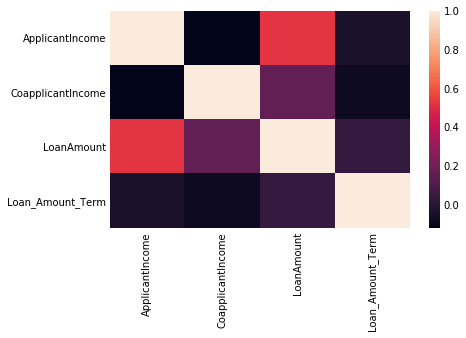

In [21]:
sns.heatmap( X_train[ratio_interval_cols].corr())

In [22]:
#Check for missing values on data
X_train.isnull().sum()


Loan_ID               0
Gender                7
Married               3
Dependents           12
Education             0
Self_Employed        28
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term     12
Credit_History       39
Property_Area         0
dtype: int64

In [23]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class CustomPandasTransformer(BaseEstimator, TransformerMixin):
    def _validate_input(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a DataFrame, but got type=%s" 
                            % type(X))
        return X
    
    @staticmethod
    def _validate_columns(X, cols):
        scols = set(X.columns)  # set for O(1) lookup
        if not all(c in scols for c in cols):
            raise ValueError("all columns must be present in X")

class DummyEncoder(CustomPandasTransformer):
    def __init__(self, columns, sep='_', drop_one_level=True, tmp_nan_rep='N/A'):
        self.columns = columns
        self.sep = sep
        self.drop_one_level = drop_one_level
        self.tmp_nan_rep = tmp_nan_rep
        
    def fit(self, X, y=None):
        # validate the input
        X = self._validate_input(X).copy()  # get a copy
        
        # parameter validation happens here:
        tmp_nan = self.tmp_nan_rep
        
        # validate all the columns present
        cols = self.columns
        self._validate_columns(X, cols)
                
        # for each column, fit a label encoder
        lab_encoders = {}
        for col in cols:
            vec = [tmp_nan if pd.isnull(v) 
                   else v for v in X[col].tolist()]
            
            # if the tmp_nan value is not present in vec, make sure it is
            # so the transform won't break down
            svec = list(set(vec))
            if tmp_nan not in svec:
                svec.append(tmp_nan)
            
            le = LabelEncoder()
            lab_encoders[col] = le.fit(svec)
            
            # transform the column, re-assign
            X[col] = le.transform(vec)
            
        # fit a single OHE on the transformed columns - but we need to ensure
        # the N/A tmp_nan vals make it into the OHE or it will break down later.
        # this is a hack - add a row of all transformed nan levels
        ohe_set = X[cols]
        ohe_nan_row = {c: lab_encoders[c].transform([tmp_nan])[0] for c in cols}
        ohe_set = ohe_set.append(ohe_nan_row, ignore_index=True)
        ohe = OneHotEncoder(sparse=False).fit(ohe_set)
        
        # assign fit params
        self.ohe_ = ohe
        self.le_ = lab_encoders
        self.cols_ = cols
        
        return self
    
    def transform(self, X):
        check_is_fitted(self, 'ohe_')
        X = self._validate_input(X).copy()
        
        # fit params that we need
        ohe = self.ohe_
        lenc = self.le_
        cols = self.cols_
        tmp_nan = self.tmp_nan_rep
        sep = self.sep
        drop = self.drop_one_level
        
        # validate the cols and the new X
        self._validate_columns(X, cols)
        col_order = []
        drops = []
        
        for col in cols:
            # get the vec from X, transform its nans if present
            vec = [tmp_nan if pd.isnull(v) 
                   else v for v in X[col].tolist()]
            
            le = lenc[col]
            vec_trans = le.transform(vec)  # str -> int
            X[col] = vec_trans
            
            # get the column names (levels) so we can predict the 
            # order of the output cols
            classes = ["%s%s%s" % (col, sep, clz) for clz in le.classes_.tolist()]
            col_order.extend(classes)
            
            # if we want to drop one, just drop the last
            if drop:
                drops.append(classes[-1])
                
        # now we can get the transformed OHE
        ohe_trans = pd.DataFrame.from_records(data=ohe.transform(X[cols]), 
                                              columns=col_order)
        
        # set the index to be equal to X's for a smooth concat
        ohe_trans.index = X.index
        
        # if we're dropping one level, do so now
        if drops:
            ohe_trans = ohe_trans.drop(drops, axis=1)
        
        # drop the original columns from X
        X = X.drop(cols, axis=1)
        
        # concat the new columns
        X = pd.concat([X, ohe_trans], axis=1)
        return X

In [24]:
# Custom Imputer to fill empty slots with most common category
from sklearn.base import TransformerMixin

class CustomCategoryImputer(BaseEstimator, TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self
# Lets make an imputer that can apply a strategy to select columns by name

class CustomQuantitativeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self
class CustomDummifier(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self
    
#ordering = ['dislike', 'somewhat like', 'like']  # 0 for dislike, 1 for somewhat like, and 2 for like

#print X['ordinal_column']

#print X['ordinal_column'].map(lambda x: ordering.index(x))
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

class CustomIdRemover(BaseEstimator, TransformerMixin):
    def __init__(self, col, ):
          self.col = col
        
    def transform(self, df):
        X = df.copy()
        X = X.drop(columns=self.col)
        return X
    
    def fit(self, *_):
        return self
    
class CustomCutter(BaseEstimator, TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self
    
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class MeanCenter(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        self.mean_ = X[self.col].mean()
        return self
    
    def transform(self, X):
        # ensure the transformer has been fit
        check_is_fitted(self, 'mean_')
        
        # always copy the input frame - we don't want to
        # impact the original frame in place
        X = X.copy()
        col = self.col
        X[col] = X[col] - self.mean_
        return X
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, dframe,cols):
         self.cols = cols
         self.dframe =dframe
        
    def transform(self, dframe):
        X = dframe.copy()
        #X[self.cols] = X[self.cols].map(lambda x: StandardScaler().fit_transform(x))
        X[self.cols] = StandardScaler().fit_transform(X[self.cols])
        return X
    
    def fit(self, *_):
        return self 
    
class CustomPoly(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
         self.cols = cols         
        
    def transform(self, df):
        X = df.copy()        
        poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
        X_poly = pd.DataFrame(poly.fit_transform(X[self.cols]),columns=poly.get_feature_names(),index=X.index)
        X=pd.concat([X, X_poly], axis=1, join_axes=[X.index])
        return X
    
    def fit(self, *_):
        return self 
    
class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # store the response series
        self.response = response
        # store the threshold that we wish to keep
        self.threshold = threshold
        # initialize a variable that will eventually
        # hold the names of the features that we wish to keep
        self.cols_to_keep = cols_to_keep
        
    def transform(self, X):
        # the transform method simply selects the appropiate
        # columns from the original dataset
        return X[self.cols_to_keep]
        
    def fit(self, X, *_):
        # create a new dataframe that holds both features and response
        df = pd.concat([X, self.response], axis=1)
        # store names of columns that meet correlation threshold
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        # only keep columns in X, for example, will remove response variable
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

In [25]:
a=nominal_cols.tolist()
a.remove('Credit_History')
b=ordinal_cols.tolist()
b.remove('Loan_ID')
b=a+b
print(b)

['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']


In [26]:
cci = CustomCategoryImputer(cols=nominal_ordinal_cols.tolist())
#cci = CustomCategoryImputer(cols=['Dependents'])
#cci.fit_transform(X_train)

cqi = CustomQuantitativeImputer(cols=ratio_interval_cols.tolist(), strategy='mean')

nom_cols=nominal_cols.tolist()
nom_cols.remove('Credit_History')
ord_cols=ordinal_cols.tolist()
ord_cols.remove('Loan_ID')
dummy_cols=nom_cols+ord_cols
cde = DummyEncoder(columns=dummy_cols)

cid=CustomIdRemover(col=['Loan_ID'])

cs=CustomScaler(X_train,cols=ratio_interval_cols.tolist())
cp=CustomPoly(cols=ratio_interval_cols.tolist())

ccc = CustomCorrelationChooser(response=y)

imputer = Pipeline([('quant', cqi) ,
                    #('cpoly',cp), 
                    ('scale',cs),('category', cci),('dummy', cde),('cid',cid)])
#imputer = Pipeline([('quant', cqi), ('category', cci)])

# function to build the pipeline
def build_pipe(est, est_name='clf'):
    return Pipeline([
            ('imputer', imputer),
            (est_name, est)
        ])

X_transformed=imputer.fit_transform(X_train)  # ready for action
#y_new = pd.DataFrame(LabelEncoder().fit_transform(y_train),columns=y_train.columnsindex=y_train.index)
Y_transformed=pd.DataFrame(LabelEncoder().fit_transform(y_train),columns=[target_col],index=y_train.index)
#X_transformed=pd.concat([X_transformed,Y_transformed],axis=1)
#im.head()
#X_transformed.corr()[target_col].abs() > .2




#sns.heatmap(im.corr())
#im.corr()['Loan_Status']

#im.isnull().sum()
#im['Married'].unique()
#cd = CustomDummifier(cols=['boolean', 'city'])

#cd.fit_transform(X)
#cc = CustomCutter(col='quantitative_column', bins=3)

#cc.fit_transform(X)

#pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])
# will use our initial imputer
# will dummify variables first
# then encode the ordinal column
# then bucket (bin) the quantitative column

In [82]:
from sklearn.model_selection import KFold

# define our cross validator - remember to shuffle!
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

In [83]:
cv_parts = list(cv.split(X_train))
print("Num splits: %i" % len(cv_parts))
for i, part in enumerate(cv_parts):
    print("Fold %i n_samples: %i" % (i, part[0].shape[0]))

Num splits: 5
Fold 0 n_samples: 368
Fold 1 n_samples: 368
Fold 2 n_samples: 368
Fold 3 n_samples: 368
Fold 4 n_samples: 368


In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Fitting a logistic regression with CV
(cross_val_score(build_pipe(LogisticRegression(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')).mean()

0.8217391304347826

In [80]:
from sklearn.svm import SVC

# Fitting an SVM
(cross_val_score(build_pipe(SVC(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')).mean()

0.8173913043478261

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest
(cross_val_score(build_pipe(RandomForestClassifier(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')).mean()

0.7543478260869566

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# the pipe we'll use
rf_pipe = Pipeline([
        ('imputer', imputer),
        ('clf', RandomForestClassifier(random_state=seed))
    ])

# define the hyper-params
hyper_params = {
    'clf__n_estimators': randint(50, 250),
    'clf__min_samples_leaf': [1, 5, 10, 25, 50],
    'clf__max_depth': randint(10, 25)
}

# define the search
rf_search = RandomizedSearchCV(rf_pipe, param_distributions=hyper_params,
                               random_state=seed, cv=cv, n_iter=5,
                               n_jobs=1, verbose=1, scoring='accuracy',
                               return_train_score=False)

#rf_search.fit(X_train, y_train)

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score
def get_best_model_and_accuracy(pipe,cv, params, X, y):
    #grid = GridSearchCV(pipe,           # the model to grid search
    #                    params,cv=cv,          # the parameter set to try 
     #                   error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid=RandomizedSearchCV(pipe, param_distributions=params,
                               random_state=seed, cv=cv, n_iter=8,
                               n_jobs=1, verbose=1, scoring='accuracy',
                               return_train_score=False,error_score=0.)
    
    grid.fit(X, y)           # fit the model and parameters
    #grid_preds = grid.predict(X_test)
    
    # our classical metric for performance
    print ("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print ("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print ("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print ("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
    
    #print("Model test score: %.5f" % accuracy_score(y_test, grid_preds))
    

 



   

In [34]:
# Import four machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Set up some parameters for our grid search
# We will start with four different machine learning models
# logistic regression, KNN, Decision Tree, and Random Forest
lr_params = {'clf__C':[1e-1, 1e0, 1e1, 1e2], 'clf__penalty':['l1', 'l2']}
svc_params = {'clf__C': uniform(0.5, 0.125),'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
tree_params = {'clf__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
forest_params = {'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [None, 1, 3, 5, 7]}


# instantiate the four machine learning models
lr = LogisticRegression(random_state=seed)
#knn = KNeighborsClassifier()
#d_tree = DecisionTreeClassifier()
#forest = RandomForestClassifier()

In [35]:
import copy
# instantiate our feature selector with the response variable set
ccc = CustomCorrelationChooser(response=Y_transformed)

# make our new pipeline, including the selector
ccc_pipe = Pipeline([('correlation_select', ccc), 
                     ('clf', lr)])

# make a copy of the decisino tree pipeline parameters
ccc_pipe_params = copy.deepcopy(lr_params)

# update that dictionary with feature selector specific parameters
ccc_pipe_params.update({
               'correlation_select__threshold':[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, .1, .2, .3]})

print(ccc_pipe_params)

# better than original (by a little, and a bit faster on 
# average overall
get_best_model_and_accuracy(ccc_pipe, cv,ccc_pipe_params, X_transformed, Y_transformed)  

{'clf__C': [0.1, 1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2'], 'correlation_select__threshold': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Accuracy: 0.8195652173913044
Best Parameters: {'correlation_select__threshold': 0.01, 'clf__penalty': 'l1', 'clf__C': 0.1}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.001


c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

In [36]:
# Variance Threshold likely will not help 
variance_pipe = Pipeline([('variance', VarianceThreshold()), 
                          ('clf', lr)])

variance_pipe_params = copy.deepcopy(lr_params)

variance_pipe_params.update({
    'variance__threshold':[.05, .1, .15, .2, .25, .3, .4, .5]
                                 })
print(variance_pipe_params)
# better than original, but a bit faster on average
get_best_model_and_accuracy(variance_pipe,cv, variance_pipe_params, X_transformed, Y_transformed)  

{'clf__C': [0.1, 1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2'], 'variance__threshold': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Accuracy: 0.8195652173913044
Best Parameters: {'variance__threshold': 0.1, 'clf__penalty': 'l2', 'clf__C': 10.0}
Average Time to Fit (s): 0.001
Average Time to Score (s): 0.0


c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

In [37]:
# SelectKBest selects features according to the k highest scores of 
# a given scoring function
from sklearn.feature_selection import SelectKBest

# This models a statistical test known as ANOVA
from sklearn.feature_selection import f_classif
# f_classif allows for negative values, not all do
# chi2 is a very common classification criteria but only 
# allows for positive values

# regression has its own statistical tests
#  keep only the best five features according to p-values of ANOVA test
k_best = SelectKBest(f_classif, k=5)

# matrix after selecting the top 5 features
k_best.fit_transform(X_transformed, Y_transformed)

k_best.pvalues_  # p values of columns

p_values = pd.DataFrame({'column': X_transformed.columns, 'p_value': k_best.pvalues_}).sort_values('p_value')

p_values.head()

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 10 11 13] are constant.
  UserWarning)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,column,p_value
4,Credit_History,1.608149e-37
15,Property_Area_Semiurban,1.229911e-02
14,Property_Area_Rural,1.928989e-02
8,Married_No,5.143798e-02
9,Education_Graduate,5.798709e-02


In [38]:
# features with a low p value
p_values[p_values['p_value'] < .05]

,column,p_value
4,Credit_History,1.608149e-37
15,Property_Area_Semiurban,1.229911e-02
14,Property_Area_Rural,1.928989e-02


In [39]:
# features with a high p value
p_values[p_values['p_value'] >= .05]

,column,p_value
8,Married_No,0.051438
9,Education_Graduate,0.057987
1,CoapplicantIncome,0.151881
18,Dependents_2,0.245736
17,Dependents_1,0.336119
19,Dependents_3+,0.337658
16,Dependents_0,0.694666
2,LoanAmount,0.733303
12,Self_Employed_No,0.834111
3,Loan_Amount_Term,0.884514


In [60]:
X_select=X_transformed[['Credit_History','Property_Area_Semiurban','Property_Area_Rural']]

In [62]:
# Fitting a logistic regression with CV
(cross_val_score(build_pipe(LogisticRegression(random_state=seed)), 
                X=X_train, y=y_train, cv=cv, scoring='accuracy')).mean()

0.8217391304347826

In [65]:
# Fitting a logistic regression with CV
(cross_val_score(LogisticRegression(random_state=seed), 
                X=X_select, y=Y_transformed, cv=cv, scoring='accuracy')).mean()

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

0.8195652173913043

In [40]:
k_best = SelectKBest(f_classif)

# Make a new pipeline with SelectKBest
select_k_pipe = Pipeline([('k_best', k_best), 
                          ('clf', lr)])

select_k_best_pipe_params = copy.deepcopy(lr_params)

select_k_best_pipe_params.update({'k_best__k':list(range(1,23))+['all'],  # the 'all' literally does nothing to subset
                                 })
print(select_k_best_pipe_params)
# comparable to our results with correlationchooser
get_best_model_and_accuracy(select_k_pipe, cv,select_k_best_pipe_params, X_transformed, Y_transformed)

{'clf__C': [0.1, 1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2'], 'k_best__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'all']}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 10 11 13] are constant.
  UserWarning)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 10 11 13] are constant.
  UserWarning)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 10 11 13] are constant.
  UserWarning)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divid

Best Accuracy: 0.8195652173913044
Best Parameters: {'k_best__k': 11, 'clf__penalty': 'l1', 'clf__C': 0.1}
Average Time to Fit (s): 0.006
Average Time to Score (s): 0.0


c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 10 11 13] are constant.
  UserWarning)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\

In [41]:
k_best = SelectKBest(f_classif, k=11)


In [42]:
pipe=build_pipe(LogisticRegression(random_state=seed))
get_best_model_and_accuracy(pipe,cv, lr_params, X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Accuracy: 0.8217391304347826
Best Parameters: {'clf__penalty': 'l2', 'clf__C': 1.0}
Average Time to Fit (s): 0.024
Average Time to Score (s): 0.013


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


In [43]:
pipe=build_pipe(SVC(random_state=seed))
#get_best_model_and_accuracy(pipe,cv, svc_params, X_train, y_train)

In [44]:
pipe=build_pipe(DecisionTreeClassifier(random_state=seed))
#get_best_model_and_accuracy(pipe,cv, tree_params, X_train, y_train)

In [45]:
pipe=build_pipe(RandomForestClassifier(random_state=seed))
#get_best_model_and_accuracy(pipe,cv, forest_params, X_train, y_train)

In [69]:
# scikit-learn's version of PCA
from sklearn.decomposition import PCA
# Like any other sklearn module, we first instantiate the class
pca = PCA(n_components=3)

In [47]:
# fit the PCA to our data
pca.fit(X_transformed)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [48]:
pca.components_

array([[ 6.86858275e-01,  6.45123937e-02,  7.09353472e-01,
        -2.78745523e-02, -3.58610360e-04, -3.54382945e-02,
         3.54382945e-02,  0.00000000e+00, -5.80310720e-02,
         6.49804422e-02,  0.00000000e+00,  0.00000000e+00,
        -4.91189210e-02, -3.94430453e-31,  1.06552886e-02,
         2.85548614e-03, -7.18273121e-02,  1.79609365e-02,
         1.05674110e-02,  4.32989645e-02],
       [-2.01487924e-01,  7.92026776e-01,  8.96718544e-02,
        -5.58644585e-01,  1.66512603e-03, -4.36400619e-02,
         4.36400619e-02, -0.00000000e+00, -5.40863628e-02,
        -7.75069326e-03,  1.05879118e-22, -1.65436123e-24,
         1.71238958e-02, -4.03896783e-28,  1.37082798e-02,
        -5.35606656e-02, -2.62170897e-02, -1.30295630e-03,
        -5.69118416e-03,  3.32112301e-02],
       [-2.10708295e-01,  5.03319130e-01,  1.96338545e-01,
         8.07456938e-01,  1.86611322e-02,  1.25313567e-02,
        -1.25313567e-02, -0.00000000e+00,  2.39538875e-02,
         4.49301330e-02, -0.0

In [49]:
pca.explained_variance_ratio_

array([0.25917343, 0.18669526, 0.16432533, 0.07761905, 0.06237655,
       0.05671428, 0.0433042 , 0.02862295, 0.02683765, 0.02281918])

In [70]:
# fit the PCA to our data
pca.fit(X_select)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [71]:
pca.explained_variance_ratio_

array([0.58764436, 0.2232753 , 0.18908033])

In [72]:
pca.fit(X_select)

X_train_pca = pca.transform(X_select)
#X_test_pca = pca.transform(X_test)

In [73]:
# Fitting a logistic regression with CV
(cross_val_score(LogisticRegression(random_state=seed), 
                X=X_train_pca, y=Y_transformed, cv=cv, scoring='accuracy')).mean()

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

0.8195652173913043

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

In [51]:
X_lda_loan = lda.fit(X_transformed,Y_transformed.values.ravel())

c:\users\dhiman\anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [52]:
lda.explained_variance_ratio_

array([1.])

In [53]:
lda.scalings_  

array([[ 5.21704407e-02],
       [-1.62969019e-01],
       [-8.67289910e-02],
       [-4.43179217e-02],
       [ 3.22729633e+00],
       [ 4.44681078e-02],
       [-4.44681078e-02],
       [ 4.10340191e-17],
       [-4.94750279e-01],
       [ 2.00907012e-01],
       [ 3.70769262e-17],
       [-1.30336505e-16],
       [ 1.18339743e-01],
       [ 6.02532332e-17],
       [-2.47640973e-01],
       [ 3.05872021e-01],
       [ 9.72384263e-02],
       [-3.14924722e-01],
       [ 1.22440872e-01],
       [ 3.90855303e-02]])

In [54]:
df.boxplot(column='ApplicantIncome', by = 'Gender')

NameError: name 'df' is not defined

In [ ]:
df['LoanAmount'].hist(bins=50)

In [ ]:
df.boxplot(column='LoanAmount')

In [ ]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan for each Credit History class:') 
print (temp2)




In [ ]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)

ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")
temp2.plot(kind = 'bar')

In [ ]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [ ]:


temp4 = df.pivot_table(values='Loan_Status',index=['Credit_History','Gender'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
#print(temp4)
temp4.plot(kind = 'bar')
temp4 = pd.crosstab(df['Credit_History'], df['Gender'])
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)


In [ ]:
#find missing values
df.apply(lambda x: sum(x.isnull()),axis=0) 

In [ ]:
df['Dependents'].value_counts()

In [ ]:
df['Loan_Amount_Term'].value_counts()

In [ ]:
df['Credit_History'].value_counts()

In [ ]:
#Impute missing values of non numeric variables :Gender, Married, Dependents, Loan_Amount_Term, Credit_History

df['Gender'].fillna(mode(df['Gender'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Married'].fillna(mode(df['Married'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Self_Employed'].fillna(mode(df['Self_Employed'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Dependents'].fillna(mode(df['Dependents'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Loan_Amount_Term'].fillna(mode(df['Loan_Amount_Term'].dropna(axis=0, how='any')).mode[0], inplace=True)
df['Credit_History'].fillna(mode(df['Credit_History'].dropna(axis=0, how='any')).mode[0], inplace=True)

In [ ]:
#Impute missing values of LoanAmount
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [ ]:
df['LoanAmount'].hist(bins=20)

In [ ]:
 df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

In [ ]:
df['CoapplicantIncome'].hist(bins=20)

In [ ]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
#df['TotalIncome_log'].hist(bins=20) 
df = df.reset_index()

In [ ]:
#Convert categorical data to numeric data
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 


In [ ]:
df.head()

In [ ]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [ ]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount','TotalIncome']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#Generally we expect the accuracy to increase on adding variables. But this is a more challenging case. The accuracy and cross-validation score are not getting impacted by less important variables. Credit_History is dominating the mode. We have two options now:
#   Feature Engineering: dereive new information and try to predict those. I will leave this to your creativity.
#    Better modeling techniques. Let’s explore this next.

In [ ]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#An advantage with Random Forest is that we can make it work with all the features 
#and it returns a feature importance matrix which can be used to select features.
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
#Here we see that the accuracy is 100% for the training set. This is the ultimate case of overfitting and can be resolved in two ways:
#    Reducing the number of predictors
#    Tuning the model parameters
#Let’s try both of these. First we see the feature importance matrix from which we’ll take the most important features.

In [ ]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

In [ ]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

In [ ]:
''' This exercise gives us some very interesting and unique learning:

#    Using a more sophisticated model does not guarantee better results.
#    Avoid using complex modeling techniques as a black box without understanding the underlying concepts. Doing so would increase the tendency of overfitting thus making your models less interpretable
#    Feature Engineering is the key to success. Everyone can use an Xgboost models but the real art 
     and creativity lies in enhancing your features to better suit the model.
'''